<a href="https://colab.research.google.com/github/Ignacio-Ibarra/NLP-Disasters/blob/tp1_nlp_disasters---edits/Nacho%20sobre_version_Ale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from wordcloud import WordCloud
import PIL
import itertools
from collections import defaultdict
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import string



%matplotlib inline

#para suprimir notacion cientifica en los outputs
pd.options.display.float_format='{:20,.2f}'.format

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Google Drive

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
link='https://drive.google.com/open?id=1Wuo42Fju9VOh2m5PV7q95TTUAIkrEwDD'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1Wuo42Fju9VOh2m5PV7q95TTUAIkrEwDD


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv')

# Carga DF

In [52]:
#Loading 'train.csv' into DataFrame
train=pd.read_csv('train.csv')
train.head(10) #Let's have a first view of the DataFrame

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [0]:
print('El DataFrame cuenta con {} filas y {} columnas'.format(train.shape[0],train.shape[1]))

El DataFrame cuenta con 7613 filas y 5 columnas


## Basic statistics

In [0]:
#Counting rows, columns, values
print('the shape is: ',train.shape)
print('the size is: ', train.size)

the shape is:  (7613, 5)
the size is:  38065


In [0]:
#Get info of each column
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [0]:
#Is there any null value per column?
train.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [0]:
#How many nulls per column? 
train.isnull().mean()*(train['id'].count()) #We know that the 'id' column has no nulls

id                         0.00
keyword                   61.00
location               2,533.00
text                       0.00
target                     0.00
dtype: float64

The 'location' column has null values ​​in 33% (2,533) of its rows, we may have to leave it out of the analysis. On the other hand, the 'keyword' column has 0.8% (61) null values

# Cleanning dataset

Vemos si hay repetidos 

In [0]:
train.duplicated().sum()

0

Vemos si haytweets que tengan textos repetidos pero con dos valores distintos de target. 

In [53]:
duplicated=train.groupby(['text']).agg({'target':['nunique']}).reset_index()
duplicated.sort_values(by=('target','nunique'),ascending=False)

,text,target
,,nunique
7265,like for the music video I want some real acti...,2
3618,Hellfire! We donÛªt even want to think about ...,2
6131,The Prophet (peace be upon him) said 'Save you...,2
4193,In #islam saving a person is equal in reward t...,2
6353,To fight bioterrorism sir.,2
...,...,...
2496,Back from Seattle Tacoma and Portland. Whirlwi...,1
2495,Baby elephant dies just days after surviving m...,1
2494,BUT I will be uploading these videos ASAP so y...,1


Existen tweets a los que se les asignaron 2 targets al mismo tiempo (columna nunique). Estos se deben elimnar ya que afectan al set de entrenamiento.

In [0]:
contradiction=train.loc[:,['text','target']].groupby(['text']).transform('nunique')

In [0]:
train['count_targets']=contradiction
train=train[train.count_targets==1]
train.drop('count_targets',axis=1,inplace=True)

In [56]:
train.count()

id          7558
keyword     7497
location    5055
text        7558
target      7558
dtype: int64

Admás completamos los null values con strings. 

In [0]:
#Filling the nulls values of both columns 
values = {'keyword': 'no_keyword', 'location': 'no_location'}
train.fillna(value=values, inplace=True)

Eliminamos la columna `id` porque ya no es necesaria. 

In [58]:
train=train.drop(columns='id')
train.shape

(7558, 4)

# Proporción de Target Real/Not Real

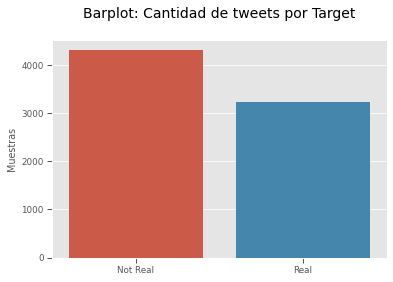

In [59]:
#Cantidad de muestras 
sns.set_context('paper')

x=train['target'].value_counts()
g=sns.barplot(x.index,x)
g.set_title('Barplot: Cantidad de tweets por Target\n',fontsize=14)
g.set_ylabel('Muestras')
plt.xticks([0, 1], ['Not Real', 'Real'])
plt.show()


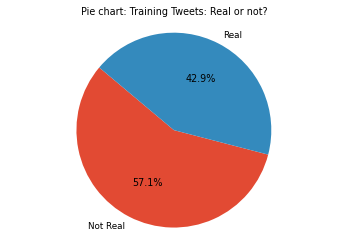

In [60]:
labels='Not Real','Real'
g2=plt.pie(x,labels=labels,autopct='%1.1f%%',startangle=140)
plt.axis('equal')
plt.title('Pie chart: Training Tweets: Real or not?')
plt.show()


Se observa mayor proporción de tweets de clase "Not Real" sobre los de clase "Real". 

Se puede dividir el DF en 2 subsets

In [0]:
train1=train[train['target']==1]
train0=train[train['target']==0]

# Análisis de Keywords

In [63]:
#Uniques values
keyword=train['keyword']
print(round(100.00*len(keyword.unique())/(len(keyword)),2),'% of the rows present unique values')

2.94 % of the rows present unique values


In [64]:
#Frecuency for each keyword. 
frequency_keywords=keyword.value_counts() 
frequency_keywords

no_keyword               61
fatalities               45
deluge                   42
armageddon               42
harm                     41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [0]:
def percent_real_disaster(x):
    return x.mean()*100 


grouped=train.groupby(['keyword']).agg({'target':[percent_real_disaster]}).sort_values(by=('target','percent_real_disaster'),ascending=False)
grouped=grouped.reset_index()


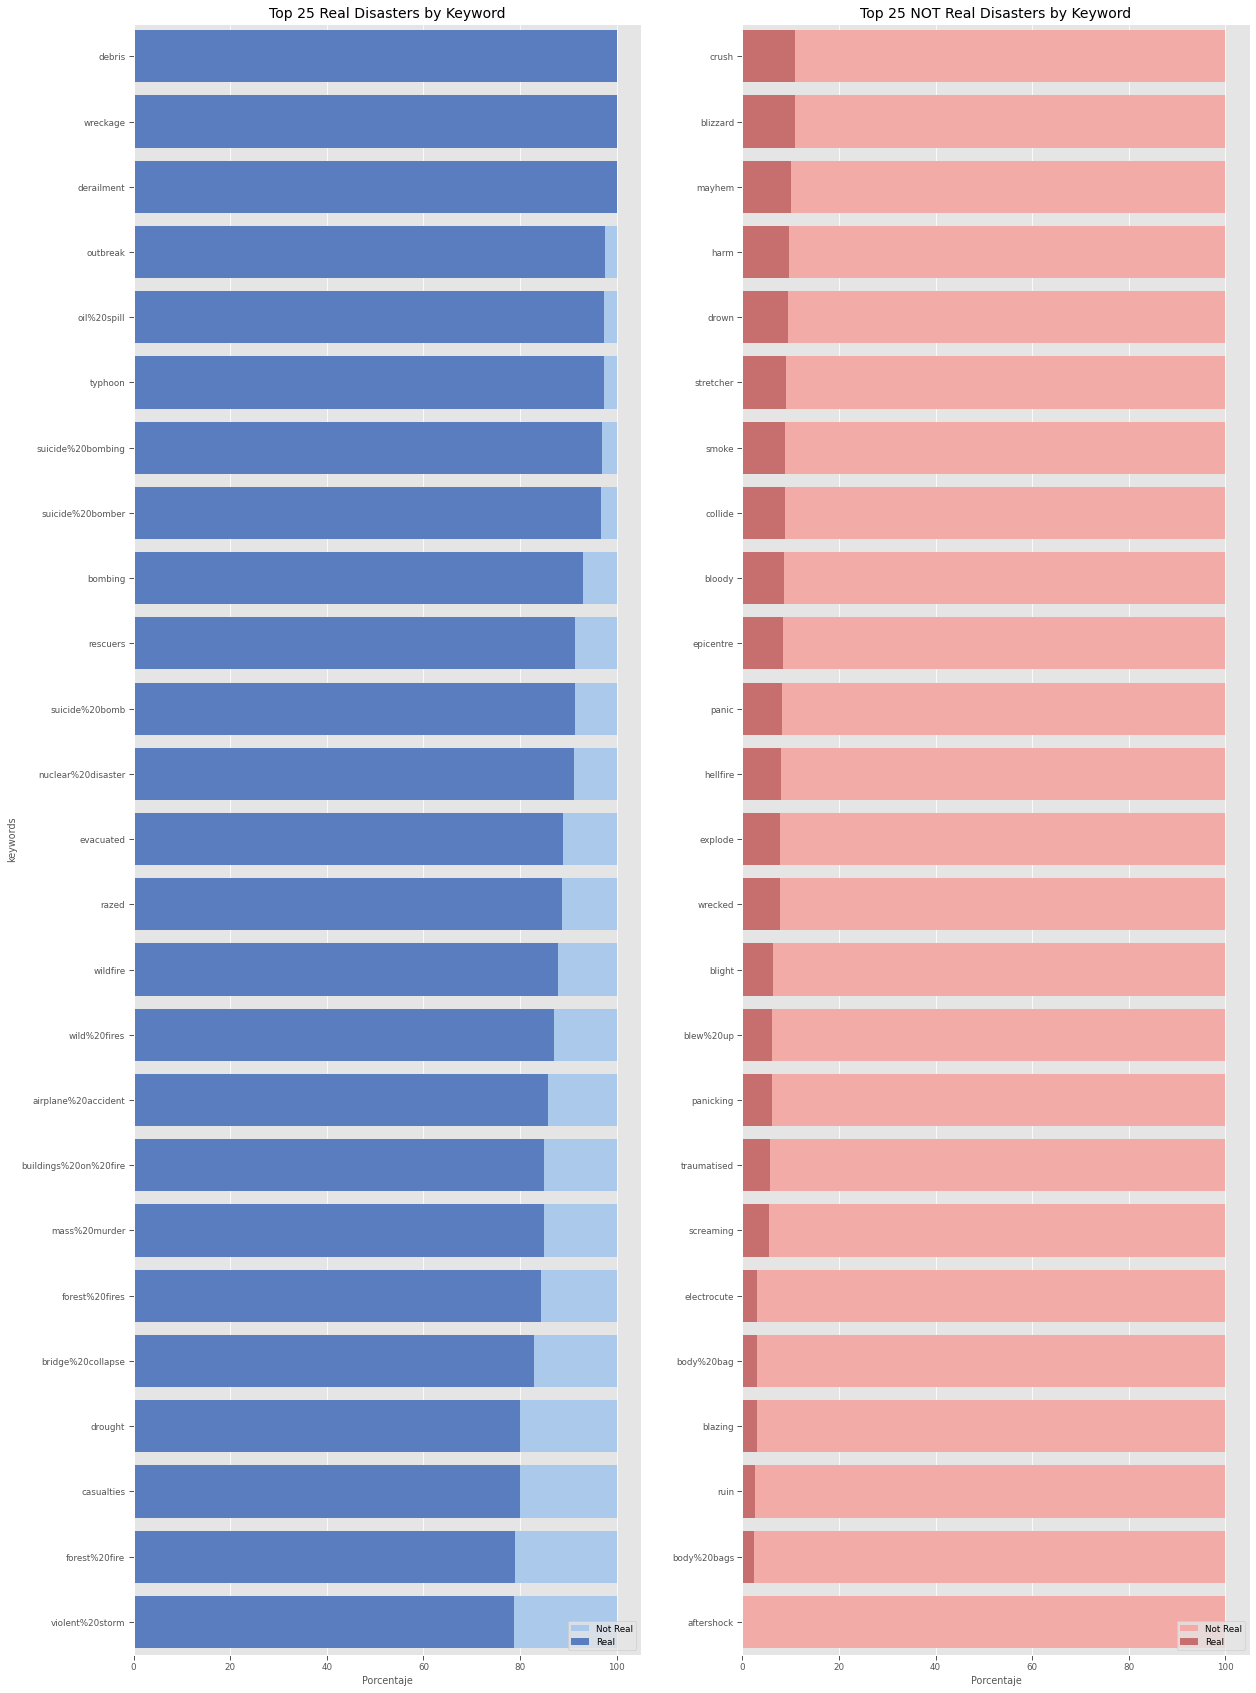

In [92]:
#Plot 
sns.set_context('paper')
#Ploteo el total de tweets por keyword
f, axes = plt.subplots(1,2, figsize=(20,30), sharex=True)

#Los keywords con mayor proporción de tweets Reales
sns.set_color_codes("pastel")
g1=sns.barplot(ax=axes[0],x=100,y='keyword',data=grouped.head(25),label='Not Real', color="b")
sns.set_color_codes("muted")
sns.barplot(ax=axes[0],x=('target','percent_real_disaster'),y='keyword',data=grouped.head(25), label='Real',color="b")
g1.set_ylabel('keywords')
g1.set_xlabel('Porcentaje')
g1.set_title('Top 25 Real Disasters by Keyword', fontsize=14)

#los peores 10
sns.set_color_codes("pastel")
g2=sns.barplot(ax=axes[1],x=100,y='keyword',data=grouped.tail(25), label='Not Real',color="r")
sns.set_color_codes("muted")
sns.barplot(ax=axes[1],x=('target','percent_real_disaster'),y='keyword',data=grouped.tail(25),label='Real', color="r")
g2.set_ylabel('')
g2.set_xlabel('Porcentaje')
g2.set_title('Top 25 NOT Real Disasters by Keyword', fontsize=14)

# Legend
g1.legend(ncol=1, loc="lower right", frameon=True)
g2.legend(ncol=1, loc="lower right", frameon=True)

plt.show()

En la figura se la izquiera se ilustran 25 keywords con porcentajes de Target "Real" mayores al 75%. Se observan keywords referentes a desastres naturales (*drought, forest fire, violent storm)* o edilicios (*bridge collapse, buildings on fire*). También se encuentran tragedias mortales (*mass murder, airplane accident, nuclear disaster, suicide bombing*). Otros keywords incluyen lenguaje de noticias (*casualties, evacuated, rescuers*). 

Por otro lado, en la figura de la derecha, se observan los 25 keywords con menores porcentajes de veracidad. En su mayoría se trata de palabras que servirían para describir tragedias pero que a su vez pueden usarse en muchos otros contextos. Un ejemplo de esto es el keyword "body bag", con un porcentaje de targets Reales menor al 5%. El término por si solo sonaría alarmante, pero veamos las acepciones de la palabra:

1.   Bolsa para guardar cadáveres
2.   Una clase de cartera/mochila
3.   Según *Urban Dictionary*, "To boddybag an oponent" es asegurar la victoria sobre el oponente (algo así como "kick ass"), es un slang muy utilizado en las batallas de rap.
4.   Otra acepción de *Urban Dictionary*, "Bodybagging" es robarle un chiste a otro comediante y hacerlo pasar como propio. 






## Keyword: frecuencias de frecuencias.  (mejorar el gráfico) 

Analizamos cuántas veces se repite cada repetición

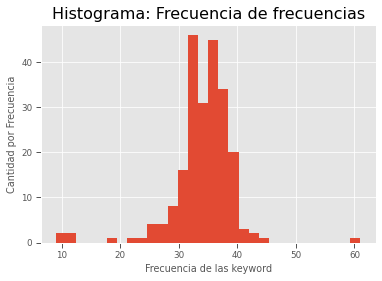

In [66]:
#Frecuency of frecuencies
freq_freq_keywords=pd.Series(frequency_keywords.values)
freq_freq_keywords.plot.hist(bins=30)
plt.title('Histograma: Frecuencia de frecuencias', fontsize =16)
plt.ylabel('Cantidad por Frecuencia')
plt.xlabel('Frecuencia de las keyword')
plt.show()

In [67]:
#Some stats 
freq_freq_keywords.describe()

count                 222.00
mean                   34.05
std                     5.14
min                     9.00
25%                    32.00
50%                    34.00
75%                    37.00
max                    61.00
dtype: float64

In [84]:
#Cuántos registros tenemos que tengan keywords con frecuencias entre 30 y 40 sobre el total de registros?
train_key_30_40=train[train.loc[:,'keyword'].isin(frequency_keywords[(frequency_keywords>=30) & (frequency_keywords<=40)].index)]
round(100*len(train_key_30_40)/len(train),2)

88.57

In [85]:
frequency_keywords[(frequency_keywords>=30) & (frequency_keywords<=40)].count()

192

¿Hay alguna relación entre el uso de la keyword y el porcentaje de veracidad?

In [0]:
grouped2=train.groupby('keyword').agg({'target':['mean','count']}).reset_index()

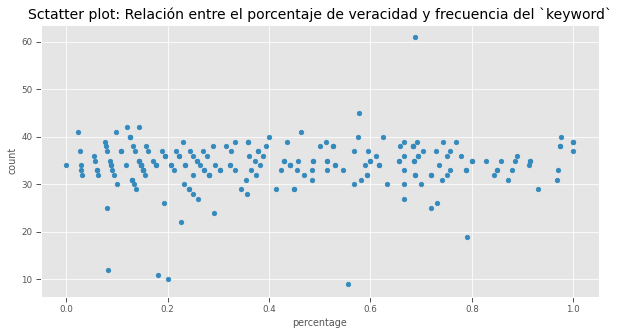

In [109]:
grouped2.columns=['keyword','percentage','count']
grouped2.plot.scatter(x='percentage',y='count',figsize=(10,5))
plt.title('Sctatter plot: Relación entre el porcentaje de veracidad y frecuencia del `keyword`',fontsize=14)
plt.show()

In [101]:
#Una correlación casi nula. 
grouped2[['percentage','count']].corr()

,percentage,count
percentage,1.00,0.08
count,0.08,1.00


# Cleaning: elimino signos de puntuación

Se eliminan los signos de puntuación salvo @, # y (:,/,.) ya que representan elementos característicos de tweets : menciones, hashtags y links. 



In [0]:

def deletePunctuation(inputString):
  aux=string.punctuation
  puncts=aux.translate(str.maketrans("#@:/.","     "))
  auxstring=" " * len(puncts)
  outputString=inputString.translate(str.maketrans(puncts,auxstring))
  return outputString

train['text'] = train['text'].apply(lambda x: deletePunctuation(x))


# Análisis de Pronombres

Se propone un análisis de cantidad de apariciones de pronombres en tweets según su target.

In [0]:
def generate_tokens(target):
    text_tokens=[]
    for x in train[train['target']==target]['text'].str.split():
        for i in x:
            text_tokens.append(i)
    return text_tokens

#Analizo tweets con target Not Real
corpus=generate_tokens(0)

dic=defaultdict(int)
pronouns={'I','me','my','mine','myself','you','your','yours','yourself',\
          'he','him','his','himself','she','her','hers','herself',\
          'it','its','itself','we','us','our','ours','ourselves',\
          'they','them','their','theirs','themselves','yourselves'}

for word in corpus:
    if word in pronouns:
        dic[word]+=1
        
top0=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:11]
x0,y=zip(*top0)
y0=tuple(i/(len(train0['text'])) for i in y)

#Analizo tweets con target Real

text_tokens=generate_tokens(1)
dic=defaultdict(int)

for word in text_tokens:
    if word in pronouns:
        dic[word]+=1

top1=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:11]
x1,y=zip(*top1)
y1=tuple(i/(len(train1['text'])) for i in y)





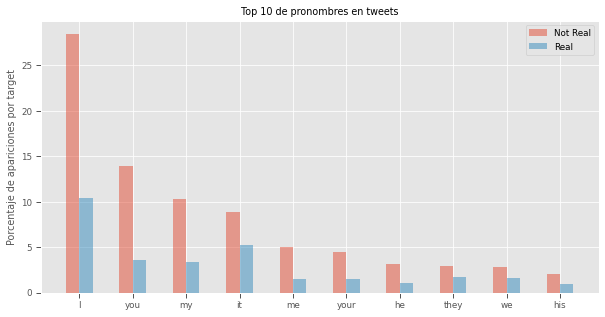

In [0]:
pronouns0=pd.DataFrame(top0,columns=['pronoun','cantidad_not_real'])
pronouns1=pd.DataFrame(top1,columns=['pronoun','cantidad_real'])

pronouns=pronouns0.merge(pronouns1, how='inner')
pronouns['cantidad_not_real']=100*pronouns['cantidad_not_real']/len(train0)
pronouns['cantidad_real']=100*pronouns['cantidad_real']/len(train1)

# Setting the positions and width for the bars
pos = list(range(len(pronouns['pronoun']))) 
width = 0.25 

# Plotting the bars
fig, ax = plt.subplots(figsize=(10,5))

# Create a bar with cantidad_not_real data,
# in position pos,
plt.bar(pos, 
        #using df['pre_score'] data,
        pronouns['cantidad_not_real'], 
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5, 
        # with label the first value in first_name
        label=pronouns['pronoun'][0]) 

# Create a bar with mid_score data,
# in position pos + some width buffer,
plt.bar([p + width for p in pos], 
        #using df['mid_score'] data,
        pronouns['cantidad_real'],
        # of width
        width, 
        # with alpha 0.5
        alpha=0.5,  
        # with label the second value in first_name
        label=pronouns['pronoun'][1]) 

# Set the y axis label
ax.set_ylabel('Porcentaje de apariciones por target')

# Set the chart's title
ax.set_title('Top 10 de pronombres en tweets')


# Set the position of the x ticks
ax.set_xticks([p + 0.5 * width for p in pos])

# Set the labels for the x ticks
ax.set_xticklabels(pronouns['pronoun'])


# Adding the legend and showing the plot
plt.legend(['Not Real', 'Real'], loc='upper right')
plt.show()

En la figura se observan los pronombres con más apariciones para ambos targets. Se observa que los mismos 10 pronombres aparecen en ambos rankings. Sin embargo, todos los porcentajes de aparición de target Not Real superan a los de target Real. En partircular, los valores de "I", "you" y "my" para los targets Not Real triplican en porcentaje a los de target Real. 
La naturaleza de un tweet que expresa un desastre responde a un estilo de redacción con poca cantidad de pronombres respecto a un tweet "normal". Esto puede deberse a que no suele usarse la primera ni segunda persona del singular, y pueden haber mayor cantidad de nombres propios.

# Análisis de características de tweets

In [0]:
def hasNumbers(inputString):
  return any(w.isdigit() for w in str(inputString).split())

train['characters_count'] = train['text'].apply(lambda x: len(str(x)))
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
train['unique_word_count'] = train['text'].apply(lambda x: len(set(str(x).split())))
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w]))
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
train['digits'] = train['text'].apply(lambda x: hasNumbers(x))


In [0]:
train
 

,id,keyword,location,text,target,characters_count,word_count,unique_word_count,url_count,hashtag_count,mention_count,digits
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,13,0,1,0,False
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,7,0,0,0,False
2,5,NaN,NaN,All residents asked to shelter in place are ...,1,133,22,18,0,0,0,False
3,6,NaN,NaN,13 000 people receive #wildfires evacuation or...,1,65,9,9,0,1,0,True
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,15,0,2,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...
7604,10863,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1,136,19,19,1,1,0,True
7605,10864,NaN,NaN,on the flip side I m at Walmart and there is a...,1,114,27,25,0,0,0,False
7606,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1,121,17,17,1,0,0,True
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,11,11,1,0,0,False


'@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C'